# Research Progress Meeting 2020-03-18
<img src="https://upload.wikimedia.org/wikipedia/commons/f/fe/Oil_Siphon_%284885250078%29.jpg" alt="Kalamazoo River oil spill" style="width:45%"> 
Image: Kalamazoo River oil spill

## Purpose

My previous analyses focused mostly on incident counts and extends of pipeline networks. But both pipeline incidents and networks are heterogeneous. Many questions I received at the PhD Research Series focused on how much oil was being spilled, and whether leaks were being contained. Therefore, I now obtained data on both the amount of oil transported (in barrel-miles) and on the amount of oil spilled.

The primary purpose will be to establish whether there are any big trends on learning or not. Where are improvements being made, where are not improvements?

---

**I.e., establish some facts.**

---

As a side note, original code is retained where it is not too complicated, to give a sense of the original dataset.

## Setup

In [1]:
library(tidyverse)
library(oildata)
library(DataAnalysisTools)
library(gridExtra)

── Attaching packages ─────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
packageVersion("oildata")

[1] ‘1.0.9’

In [3]:
head(pipelines)

year,commodity,ID,name,offshore_share,on_offshore,hca,miles,volume_crude,volume_hvl,⋯,estimate_volume_all,volume_specific,estimate_volume_specific,incidents,significant_incidents,serious_incidents,incidents_volume,significant_incidents_volume,incidents_cost,significant_incidents_cost
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2008,crude,11733,Loop,0.2008889,total,38.25,112.5,40852116635,0,⋯,40852116635,40852116635,40852116635,0,0,0,0,0,0,0
2008,crude,11733,Loop,0.2008889,offshore,3.00,22.6,NA,NA,⋯,8206736320,NA,8206736320,0,0,0,0,0,0,0
2008,crude,11733,Loop,0.2008889,onshore,35.25,89.9,NA,NA,⋯,32645380315,NA,32645380315,0,0,0,0,0,0,0
2008,hvl,3156,Davis Gas Processing,0.0000000,total,1.00,30.0,0,48,⋯,48,48,48,0,0,0,0,0,0,0
2008,hvl,3156,Davis Gas Processing,0.0000000,offshore,0.00,0.0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2008,hvl,3156,Davis Gas Processing,0.0000000,onshore,1.00,30.0,0,48,⋯,48,48,48,0,0,0,0,0,0,0


### Transform

In [4]:
pipelines_year <- pipelines %>%
    filter(commodity %in% c("crude", "hvl", "rpp")) %>%
    group_by(year, on_offshore) %>%
    summarize(!!! oildata::pipelines_consolidation) %>%
    pivot_longer(cols = -c(year, on_offshore), names_to = "variable", values_to = "value")

glimpse(pipelines_year)

Observations: 945
Variables: 4
Groups: year [15]
$ year        <dbl> 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 200…
$ on_offshore <chr> "offshore", "offshore", "offshore", "offshore", "offshore…
$ variable    <chr> "hca", "miles", "volume_crude", "volume_hvl", "volume_rpp…
$ value       <dbl> 1.000900e+03, 5.085560e+03, NA, NA, NA, NA, 1.675448e+11,…


In [5]:
pipelines_y_c <- pipelines %>%
    filter(on_offshore == "onshore") %>%
    filter(commodity %in% c("crude", "hvl", "rpp")) %>%
    group_by(year, commodity) %>%
    summarize(!!! oildata::pipelines_consolidation) %>%
    mutate(cost_per_mile = incidents_cost/miles, 
           cost_per_volume = incidents_cost/estimate_volume_all, 
           volume_per_mile = incidents_volume/miles,
           volume_per_volume = incidents_volume/estimate_volume_all,
           inc_per_mile = incidents/miles, 
           inc_per_volume = incidents/estimate_volume_all,
           sign_inc_per_mile = significant_incidents/miles,
           sign_inc_per_volume = significant_incidents/estimate_volume_all) %>%
    pivot_longer(cols = -c(year, commodity), names_to = "variable", values_to = "value")

glimpse(pipelines_y_c)

Observations: 1,305
Variables: 4
Groups: year [15]
$ year      <dbl> 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004,…
$ commodity <chr> "crude", "crude", "crude", "crude", "crude", "crude", "crud…
$ variable  <chr> "hca", "miles", "volume_crude", "volume_hvl", "volume_rpp",…
$ value     <dbl> 1.754843e+04, 4.419932e+04, NA, NA, NA, NA, 1.803125e+12, 1…


## About the data

In [6]:
unique(pipelines_year$variable)

[1] "hca"                          "miles"                       
 [3] "volume_crude"                 "volume_hvl"                  
 [5] "volume_rpp"                   "volume_other"                
 [7] "estimate_volume_crude"        "estimate_volume_hvl"         
 [9] "estimate_volume_rpp"          "estimate_volume_other"       
[11] "volume_all"                   "estimate_volume_all"         
[13] "volume_specific"              "estimate_volume_specific"    
[15] "incidents"                    "significant_incidents"       
[17] "serious_incidents"            "incidents_volume"            
[19] "significant_incidents_volume" "incidents_cost"              
[21] "significant_incidents_cost"

## Volume estimates

Prior to 2010, the PHMSA does not differentiate betwen on and offshroe pipeline miles. They do however provide separate columns on what volume is transported onshore and offshore. For the purpose of this inquiry, I constructed columns which contain the actual values for 2010 onward (or where available) and an approximation for other values. The approximation takes the value of the share of offshore (or onshore) to total pipeline miles multiplied by the total volume transported.

$v_{est\_off} = \frac{miles_{off}}{miles_{on} + miles_{off}} * v_{total}$

## How much oil is being transported and spilled?

### Looking at both onshore and offshore

#### Pipeline network

In [7]:
overview <- pipelines_year %>%
    filter(variable %in% c("miles", "volume_all", "estimate_volume_all", "estimate_volume_specific")) %>%
    ggplot(aes(x = year, y = value)) +
        facet_wrap(on_offshore ~ variable, scales = "free") +
        geom_line()

options(repr.plot.width=8, repr.plot.height=6)

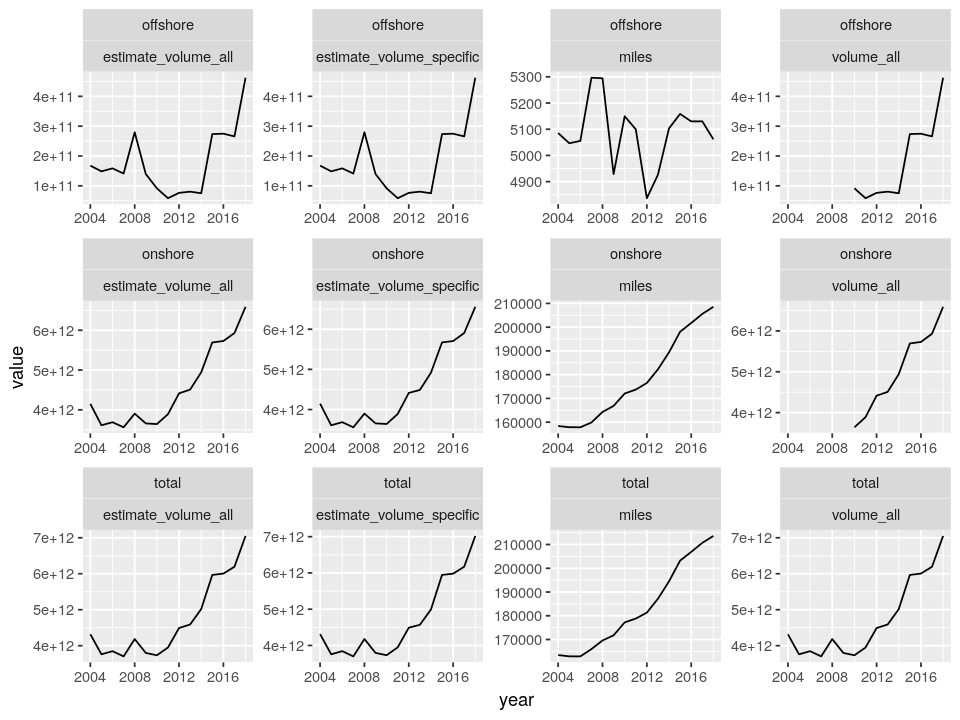

In [8]:
overview

* The volume transported increases in all cases.

* The three variables, volume_all, estimate_volume_specific, and estimate_volume_all are very similar, so we do not have to worry about variable selection too much.

* In the case of offshore production, the product is increase without a corresponding increase in pipeline miles.

* The divergence in more oil being transported for offshore might be due to unceratinty in eventual outpul of wells, and because of different througput (i.e., different diameters).

#### Details

In [9]:
details_1 <- pipelines_year %>%
    filter(on_offshore %in% c("total")) %>%
    filter(variable %in% c("miles", "estimate_volume_all")) %>%
    ggplot(aes(x = year, y = value)) +
        facet_wrap(on_offshore ~ variable, scales = "free") +
        geom_line() + 
        scale_y_continuous(limits = c(0, NA))

options(repr.plot.width=8, repr.plot.height=4)

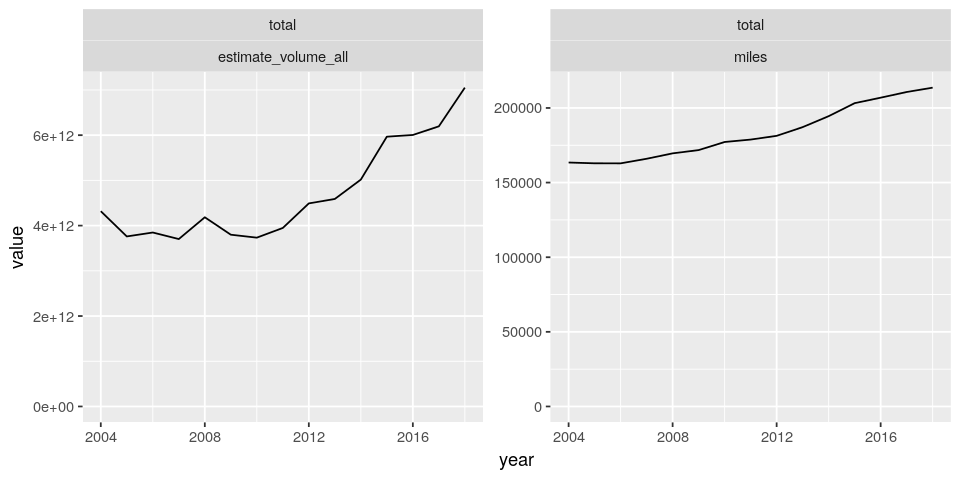

In [10]:
details_1

The comparison shows that the uptick in volume transported is much more significant than that in pipeline miles. Existing pipelines are used to transport more oil, or pipelines with larger diameters are used, supposedly because of the fracking boom.

In [11]:
details_2_volume <- pipelines_year %>%
    filter(variable %in% c("estimate_volume_all")) %>%
    filter(on_offshore %in% c("onshore", "offshore")) %>%
    ggplot(aes(x = year, y = value)) +
        facet_wrap(variable ~ on_offshore) +
        geom_line() + 
        labs(x = NULL)

details_2_miles <- pipelines_year %>%
    filter(variable %in% c("miles")) %>%
    filter(on_offshore %in% c("onshore", "offshore")) %>%
    ggplot(aes(x = year, y = value)) +
        facet_wrap(variable ~ on_offshore) +
        geom_line() + 
        labs(x = NULL)

In [12]:
volume_miles_on_offshore <- arrangeGrob(details_2_volume, details_2_miles, ncol=1)

options(repr.plot.width=8, repr.plot.height=5)

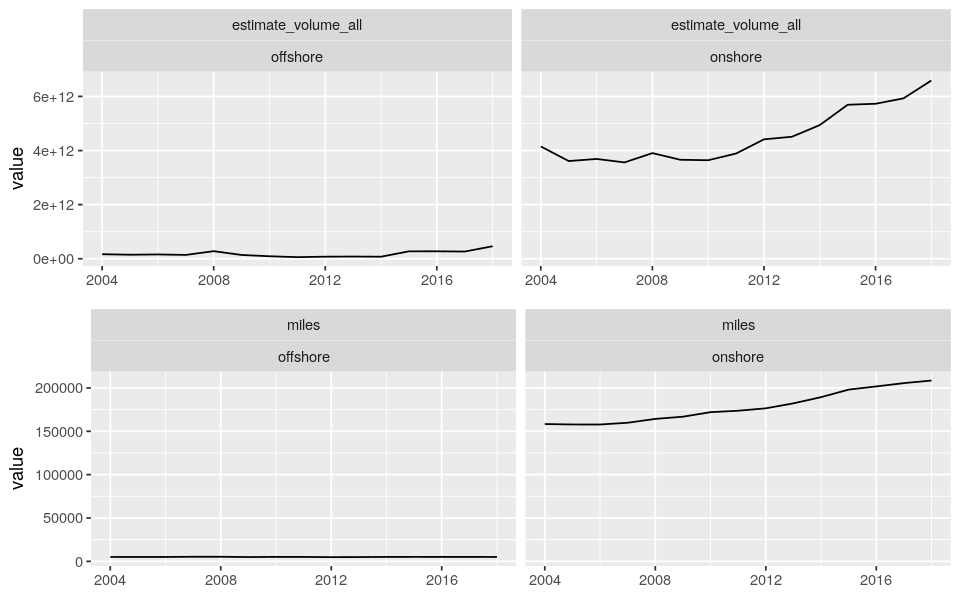

In [13]:
grid::grid.draw(volume_miles_on_offshore)

Both offshore pipeline networks and volume transported is dwarfed by onshore.

### Looking and both onshore and offshore

### Incidents

In [14]:
overview_spills <- pipelines_year %>%
    filter(variable %in% c("incidents_cost", "incidents_volume", "significant_incidents", "estimate_volume_all")) %>%
    ggplot(aes(x = year, y = value)) +
        facet_wrap(on_offshore ~ variable, scales = "free") +
        geom_line() +
        geom_smooth(method = "lm", se = FALSE)

options(repr.plot.width=8, repr.plot.height=6)

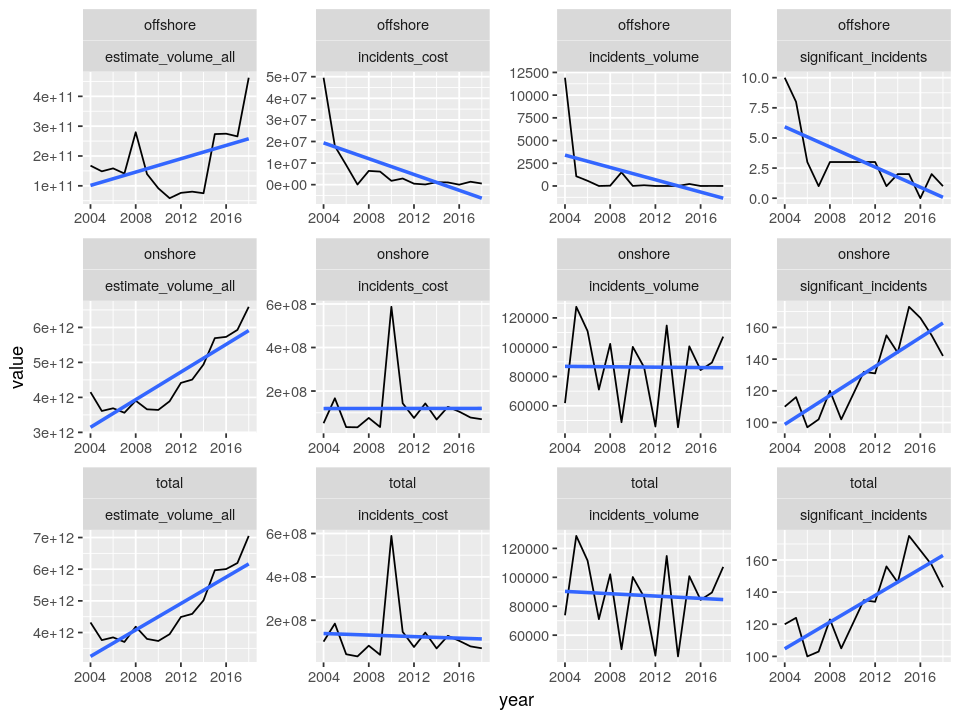

In [15]:
overview_spills

Obviously, this initially looks promising - with the volume being transported increasing, the volume of oil being spilled stays constant.

---

A look at the row offshore immediately reveals a weakness of the dataset: The Deepwater Horizon oil spill is not captured, because this spill occured directly at the source.

---

Further, the comperison of the three rows reveals that overall, offshore is just a small drop in the bucket. The trends are somewhat parallel (except for the year 2004 for offshore), and onshore far outscales offshore.

There is also a spike in 2009: Kalamazoo River oil spill - second largest in history.

---

Moving forward, I will analyse the heterogeneity in progress between different commodities, for onshore - Crude, Highly Volatile Liquids, and Refined Petroleum Products.

## Noteworthy spills

### What is that cost spike in 2009 for *onshore*?!

In [16]:
subset(incidents, on_offshore == "onshore" & cost_1984 > 1e+8, -narrative)

DATAFILE_AS_OF,significant,serious,ID,name,year,lat,long,cost,cost_1984,⋯,installation_year,FATAL,INJURE,cause,CAUSE_DETAILS,MAP_CAUSE,MAP_SUBCAUSE,SPILL_TYPE_CATEGORY,volume,date
<dttm>,<lgl>,<lgl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<date>
2020-01-30 04:18:51,TRUE,FALSE,11169,"Enbridge Energy, Limited Partnership",2010,42.24329,-84.97251,840526118,460446182,⋯,1969,NA,NA,material,ENVIRONMENTAL CRACKING-RELATED,MATERIAL/WELD/EQUIP FAILURE,ENVIRONMENTAL CRACKING-RELATED,LARGE,20082,2010-07-25


It is the Kalamazoo River oil spill.

https://en.wikipedia.org/wiki/Kalamazoo_River_oil_spill

In [17]:
subset(incidents, round(cost_1984) == 460446182)$narrative %>%
    jupyter_styling(font_size = 14)

x
"On july 26, 2010, enbridge confirmed a mainline rupture on line 6b at mp608.2452. During the investigation it was determined that the rupture occurred simultaneously with a scheduled pipeline shutdown. As a result of the incident phmsa issued a corrective action order that ordered the pipeline to remain shut down until such time that the activities outlined in the cao were satisfied. Enbridge satisfied all conditions of the cao and received approval from phmsa to resume operations on september 27, 2010 at which time enbridge successfully restarted the line. Of further note, while the telephonic report to the nrc is stated as 13:33 on july 26, 2010, enbridge made a call to nrc and was on hold for a period of time. Enbridge then hung up the call and called again at which time it was on hold for a further period of time. The stated 13:33 reflects the time that enbridge was able to provide verbal notification of the incident. The release was initially estimated at 19,500 barrels of which an undetermined amount entered the talmadge creek and ultimately the kalamazoo river. The amount of estimated product released in or reaching water has not yet been confirmed and is based upon a calculation provided by an external consultant. The amount of oil that reached water is subject to further investigation. Enbridge is currently reviewing several methodologies to calculate this volume, and will communicate the methodology and subsequent volume to phmsa upon completion. The section that failed has been sent to a laboratory for a metallurgical analysis, under the direction of ntsb. Pending the results of metallurgical testing and failure investigations, enbridge is unable to provide complete and final data for this original report submission. Information contained in this report is to be considered estimated until supplemental and final reports are filed. Ntsb, phmsa and enbridge investigations into this accident have commenced. As this investigation is ongoing, the primary and secondary cause(s) have not been finalized. To date, enbridge has not found any potable water sources (public or private) with drinking water contamination that has been verifiably linked to the enbridge release. The assessment of all drinking water sources in the affected area is ongoing. Enbridge is in the process of sampling drinking water sources and is working directly with state and local public health officials in evaluating drinking water from potable wells to ensure public health. Enbridge estimated that it will incur aggregate charges between $300 million and $400 million. These charges include emergency response, environmental remediation and cleanup activities associated with the crude oil release, costs to repair the pipeline and related inspection costs, potential claims by third parties, and lost revenue. We continue to work to accurately project the total cost of the leak and its remediation, however we are unable to break it down into the specific detail requested in this form due to the complexity of the efforts. As further information becomes known, supplemental reports will be filed as required. See attached uploaded file for supplemental narrative as of december 20, 2010. See attached uploaded file for supplemental narrative as of february 22, 2011. See attached uploaded file for supplemental narrative as of march 6, 2012. See attached uploaded file for supplemental narrative as of june 28, 2013."


### What happened with offshore in '04?

In [18]:
subset(incidents, on_offshore == "offshore" & cost_1984 > 1e+7, -c(narrative, DATAFILE_AS_OF, significant, TOTAL_COST_CURRENT))

serious,ID,name,year,lat,long,cost,cost_1984,commodity,on_offshore,installation_year,FATAL,INJURE,cause,CAUSE_DETAILS,MAP_CAUSE,MAP_SUBCAUSE,SPILL_TYPE_CATEGORY,volume,date
<lgl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<date>
FALSE,30969,Main Pass Oil Gathering System,2004,NA,NA,17600200,10968391,crude,offshore,1996,0,0,natural_forces,HIGH WINDS,NATURAL FORCE DAMAGE,HIGH WINDS,LARGE,5,2004-10-25
FALSE,2731,Chevron Pipe Line,2004,NA,NA,24000200,14956852,crude,offshore,NA,0,0,natural_forces,EARTH MOVEMENT,NATURAL FORCE DAMAGE,EARTH MOVEMENT,LARGE,4,2004-10-17


In [19]:
subset(incidents, round(cost_1984) == 14956852)$narrative

[1] "The subject pipeline was unintentionally moved by a underwater mud-slide that was generated by wave action by hurricane ivan.  The pipeline was torn in two by the forces of the mud-slide.  The seperation took place in south pass 38.  The pipeline was eventually located on october 18, 2004.    The leak duration in part g, item 3 is listed as 0-days and 0-hours because when the pipe was seperated it was shut-in for hurricane ivan and the spill was instantaneous."

In [20]:
subset(incidents, round(cost_1984) == 10968391)$narrative

[1] "During post-storm impact from hurricane ivan visible oil sheens were observed and reported near bp's main pass oil gathering pipeline in the vicinity of main pass block 69.  The oil sheens reported on 10-1-04 were fingerprinted and later confirmed as product transported in shell's 18\" pipeline.  During bp's post-storm assessments for the main pass oil gathering pipeline it was also confirmed that required separation was lost between the main pass oil gathering pipeline and shell's 18\" pipeline in the vicinity of main pass block 69.  It was during the operation of separating these two pipelines that the release from the main pass oil gathering pipeline occurred. The 10-26-04 leak was confirmed during a lifting of shell's equilon 18\" pipeline which was was located above and physically contacting the main pass oil gathering pipeline.  Just prior to the lifting of the shell pipeline, divers had removed the shell pipeline concrete coating with waterblasting equipment.  The bare portion of the lower main pass oil gathering pipeline was then examined and identified as having small pinholes in the vicinity of the contact point between the two pipelines, thus allowing crude oil to be released to receiving waters.  During this operation recovery equipment was in place and collecting all crude oil being released from the pipeline."

* The Chevron incident is the direct result of Hurricane Ivan in 2004:
    * https://en.wikipedia.org/wiki/Hurricane_Ivan
    * https://www.nytimes.com/2005/08/05/business/gulf-hurricanes-arelatest-kink-in-oil-chain.html
* Less information can be found on the damage to BP's offshore pipeline, but it is related to Hurrican Ivan also. The Hurricane cause earth movement, which for instance caused the Taylor Oil Spill. The Taylor platform used to belong to BP, so it seems likely that the same event also damaged a pipeline of BP in the area.
    * https://en.wikipedia.org/wiki/Taylor_oil_spill

## How are the spills developing, relative to volume transported?

### Briefly - how does the utilization of pipelines change over time

In [21]:
volume_miles_by_commodity <- pipelines_y_c %>%
    filter(variable %in% c("estimate_volume_specific", "miles")) %>%
    pivot_wider(names_from="variable", values_from="value") %>%
    group_by(commodity) %>%
    arrange(desc(year)) %>%
    mutate(estimate_volume_specific = estimate_volume_specific / lead(estimate_volume_specific), 
           miles = miles / lead(miles)) %>%
    pivot_longer(cols = -c(year, commodity), names_to = "variable", values_to = "value") %>%
    ggplot(aes(x=year, y=value, color=commodity)) + 
        facet_wrap(~ variable, scale = "free", ncol = 1) +
        geom_point() +
        geom_line() +
        labs(title = "Change in volume transported", y = "Volume transported YoY change (in %)")

options(repr.plot.width=8, repr.plot.height=4)

Warning message:
“Removed 6 rows containing missing values (geom_point).”Warning message:
“Removed 3 rows containing missing values (geom_path).”

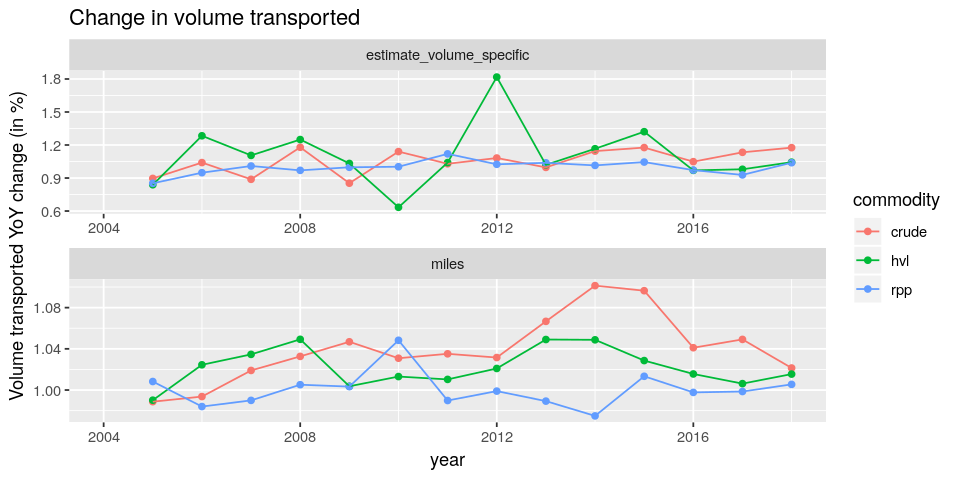

In [22]:
volume_miles_by_commodity

There are more Highly Volatile Liquids (HVL) being transported without so much new pipelines being constructed. In contrast, modest increases in crude transported correspond to many new pipeline miles being constructed.

In [23]:
standardized_1 <- pipelines_y_c %>%
    filter(variable %in% c("inc_per_mile", "inc_per_volume", "sign_inc_per_mile", "sign_inc_per_volume")) %>%
    ggplot(aes(x = year, y = value)) +
        facet_wrap(commodity ~ variable, scales = "free") +
        geom_line() +
        geom_smooth(method = "lm")

standardized_2 <- pipelines_y_c %>%
    filter(variable %in% c("cost_per_mile", "cost_per_volume", "volume_per_mile", "volume_per_volume")) %>%
    ggplot(aes(x = year, y = value)) +
        facet_wrap(commodity ~ variable, scales = "free") +
        geom_line() +
        geom_smooth(method = "lm")

options(repr.plot.width=8, repr.plot.height=6)

### So... How do spills develop relative to volume transported?

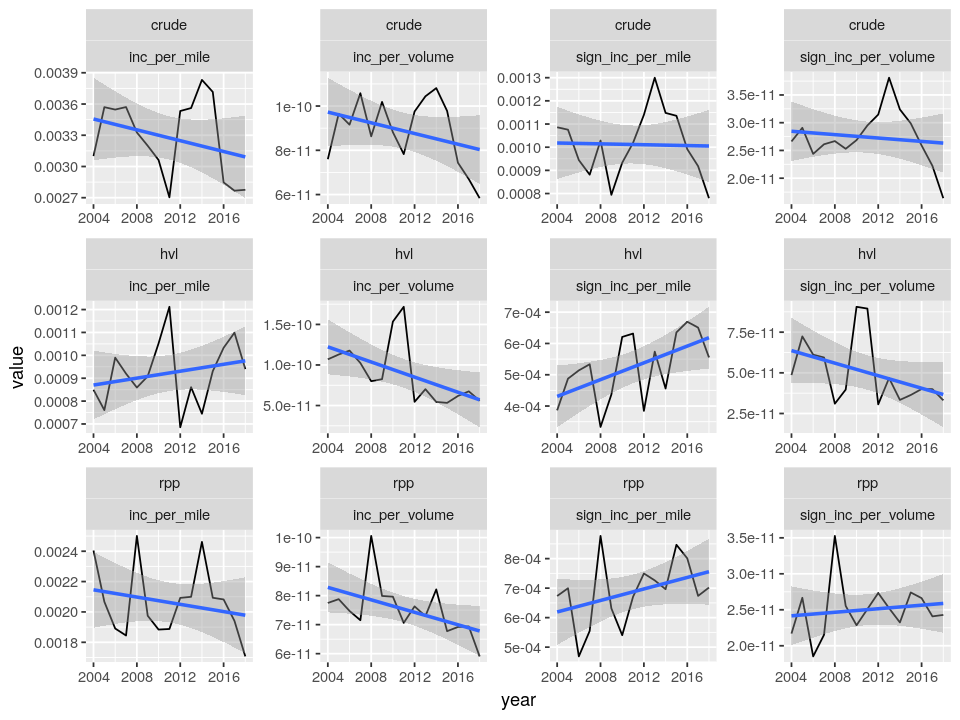

In [24]:
standardized_1

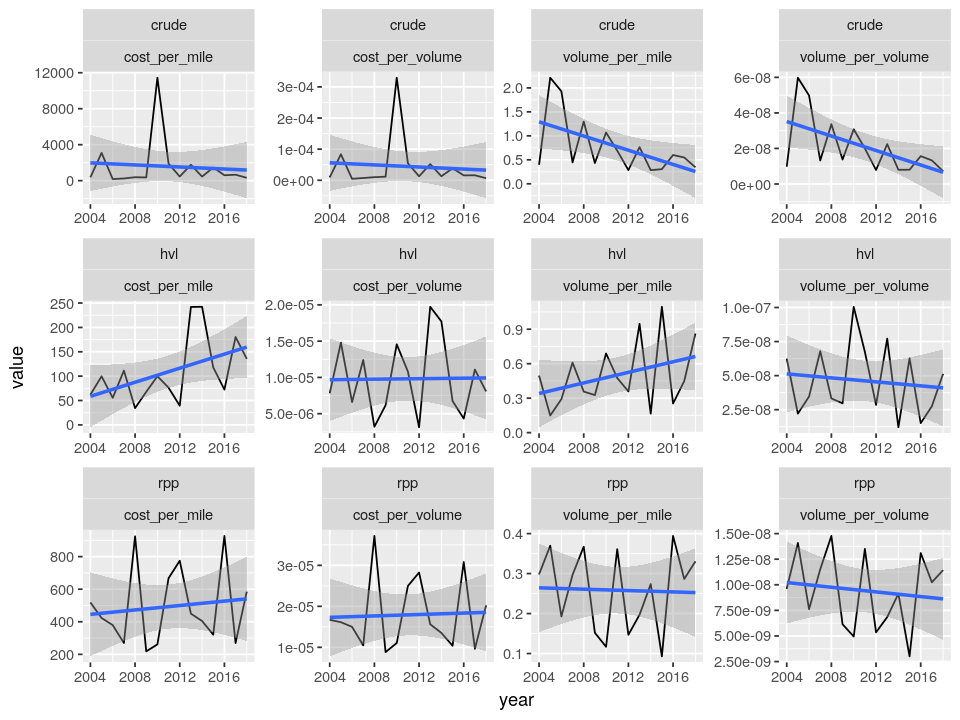

In [25]:
standardized_2

* Trends are parallel (between volume and miles) for Crude and (mostly) for Refined and Petroleum Products (RPP). But not for Highly Volatile Liquids (HVL).

* HVL benefited most from the fracking boom - existing pipelines saw a sligthly higher utilization rate. Hence diverging trends are possible.

* The most noteworthy development is that the (standardized by volume) cost of incidents is staying constant, while the (standardized by volume) volume spilled is decreasing.

* Cost here only captures the property damage - which might be negligable.

* But what really stands out is that it seems improvements are being made (in terms of volume spilled per volume transported_ for crude, some for RPP, and almost none for HVL

* With the higher utilization rate of HVL pipelines, they seem to exhibit more spills per mile, which is covered somewhat by higher throughput.

---

-> It would be fair to say that these pipelines are not getting safer

## What is the scale of performance difference between commoditites?

Does safety performance converge?

In [26]:
options(repr.plot.width=8, repr.plot.height=3.5)

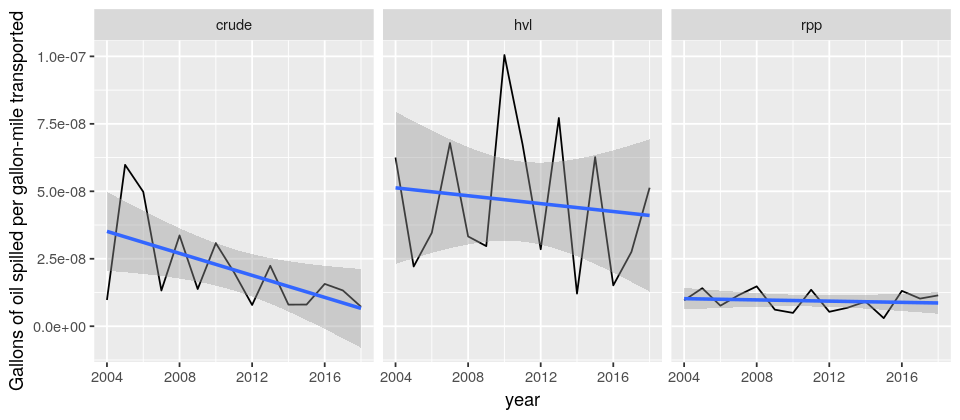

In [27]:
pipelines_y_c %>%
    filter(variable == "volume_per_volume") %>%
    ggplot(aes(x=year, y=value)) + 
        facet_wrap(~commodity) +
        geom_line() +
        geom_smooth(method = "lm") +
        labs(y = "Gallons of oil spilled per gallon-mile transported")

The divergence in scale might be explained by difference in density. Only for crude is learning obvious.

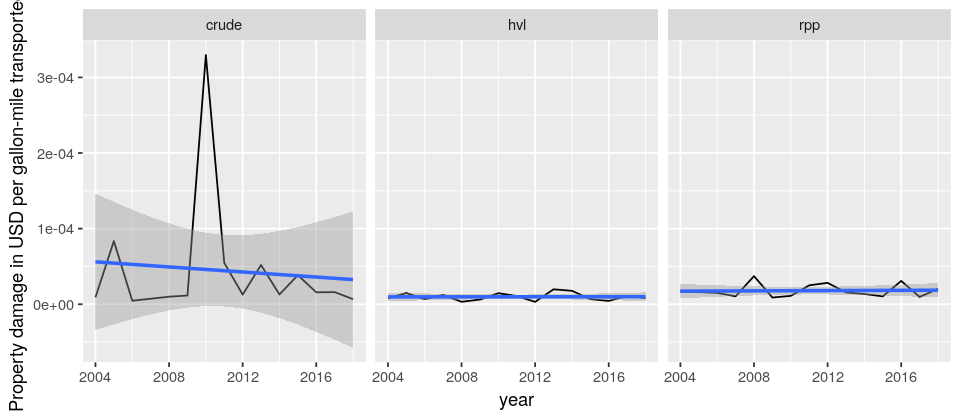

In [28]:
pipelines_y_c %>%
    filter(variable == "cost_per_volume") %>%
    ggplot(aes(x=year, y=value)) + 
        facet_wrap(~commodity) +
        geom_line() +
        geom_smooth(method = "lm") +
        labs(y = "Property damage in USD per gallon-mile transported")

Only crude incures noteworthy cost. Likely corresponds to legal cost, too. Maybe the motivation for improvements.

In [29]:
cost_graph <- pipelines_y_c %>%
    filter(variable == "cost_per_volume") %>%
    ggplot(aes(x=year, y=value)) + 
        facet_wrap(~commodity) +
        geom_line() +
        geom_smooth(method = "lm") +
        labs(y = "Cost of damage by oil spills in USD per gallon-mile transported") +
        scale_y_log10() +
        labs(title = "!!! Cost - log scaled !!!")

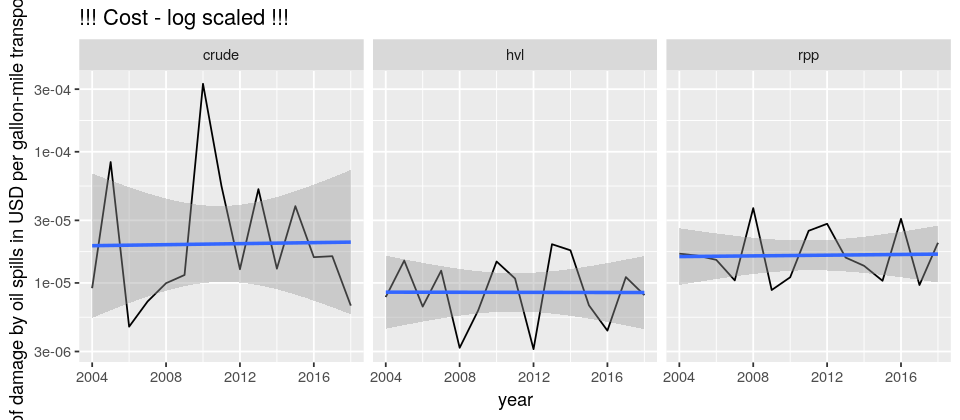

In [30]:
cost_graph

Log scale reveals that there is a cost difference betweden HVL and RPP after all. Maybe explaining why there is less improvements for HVL than for RPP.

## Heterogeneity between organizations

Prominent operators

In [31]:
largest_companies <- pipelines %>%
    filter(on_offshore == "onshore") %>%
    filter(commodity %in% c("rpp", "crude", "hvl")) %>%
    group_by(year, ID) %>%
    summarize(miles = sum(miles, na.rm = T)) %>%
    group_by(ID) %>%
    filter(miles == max(miles)) %>%
    ungroup() %>%
    top_n(6, miles) %>%
    arrange(desc(miles))

largest_companies %>%
    jupyter_styling(font_size = 14)

year,ID,miles
2015,31618,22394.73
2018,Energy Transfer Partners (Group),14658.88
2006,Kinder Morgan (Group),14004.22
2017,Magellan (Group),12943.07
2005,Phillips 66 (Group),12000.00
2018,ONEOK (Group),11792.19


In [32]:
add_company_names(31618)

[1] "Enterprise Products Operating"

In [33]:
operators <- pipelines %>%
    filter(ID %in% c("31618", "Energy Transfer Partners (Group)", "Kinder Morgan (Group)")) %>%
    mutate(ID = add_company_names(ID)) %>%
    filter(on_offshore == "onshore") %>%
    filter(commodity %in% c("crude", "hvl", "rpp")) %>%
    group_by(year, commodity, ID) %>%
    summarize(!!! oildata::pipelines_consolidation) %>%
    mutate(cost_per_mile = incidents_cost/miles, 
           cost_per_volume = incidents_cost/estimate_volume_all, 
           volume_per_mile = incidents_volume/miles,
           volume_per_volume = incidents_volume/estimate_volume_all) %>%
    pivot_longer(cols = -c(year, commodity, ID), names_to = "variable", values_to = "value")
glimpse(operators)


options(repr.plot.width=8, repr.plot.height=6)

Observations: 2,775
Variables: 5
Groups: year, commodity [45]
$ year      <dbl> 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004,…
$ commodity <chr> "crude", "crude", "crude", "crude", "crude", "crude", "crud…
$ ID        <chr> "Enterprise Products Operating", "Enterprise Products Opera…
$ variable  <chr> "hca", "miles", "volume_crude", "volume_hvl", "volume_rpp",…
$ value     <dbl> 69, 69, NA, NA, NA, NA, 1204963486, 0, 0, 0, NA, 1204963486…


### Volume transported and volume spilled

In [34]:
enterprise_products <- operators %>%
    filter(ID == "Enterprise Products Operating") %>%
    filter(variable %in% c("estimate_volume_all", "incidents_volume", "volume_per_volume", "miles")) %>%
    ggplot(aes(x=year, y=value)) +
        facet_wrap(commodity ~ variable, nrow = 3, scale = "free") +
        geom_point() +
        geom_smooth(method = "lm", se = T) +
        labs(title = "Enterprise Products Operating", x = NULL, y = NULL)

energy_transfer_partners <- operators %>%
    filter(ID == "Energy Transfer Partners (Group)") %>%
    filter(variable %in% c("estimate_volume_all", "incidents_volume", "volume_per_volume", "miles")) %>%
    ggplot(aes(x=year, y=value)) +
        facet_wrap(commodity ~ variable, nrow = 3, scale = "free") +
        geom_point() +
        geom_smooth(method = "lm", se = T) +
        labs(title = "Energy Transfer Partners", x = NULL, y = NULL)

kinder_morgan <- operators %>%
    filter(ID == "Kinder Morgan (Group)") %>%
    filter(variable %in% c("estimate_volume_all", "incidents_volume", "volume_per_volume", "miles")) %>%
    ggplot(aes(x=year, y=value)) +
        facet_wrap(commodity ~ variable, nrow = 3, scale = "free") +
        geom_point() +
        geom_smooth(method = "lm", se = T) +
        labs(title = "Kinder Morgan", x = NULL, y = NULL)

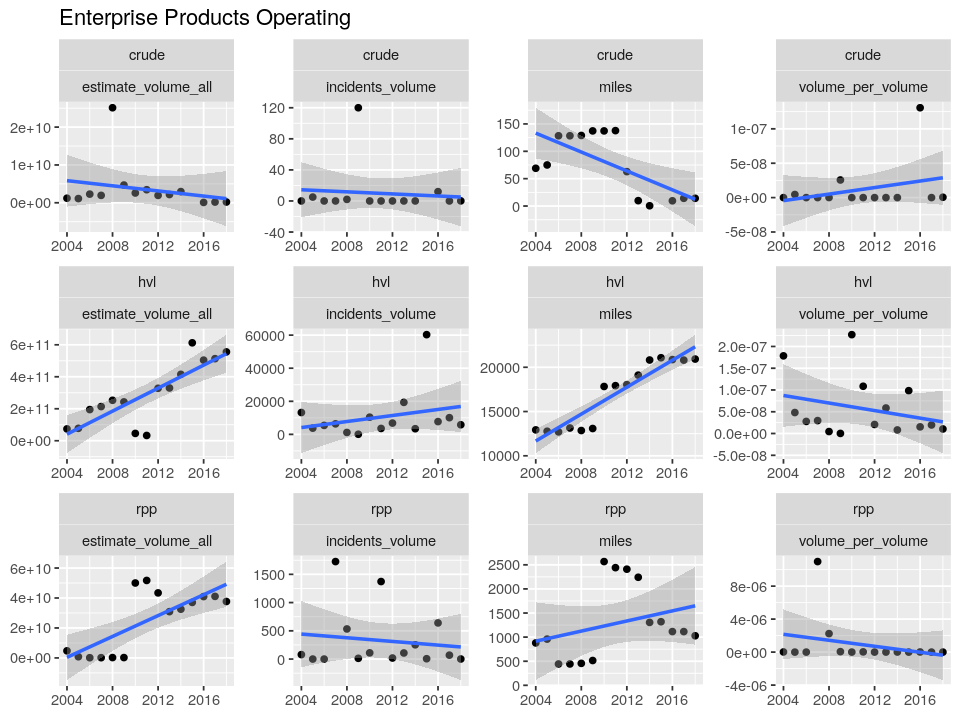

In [35]:
enterprise_products

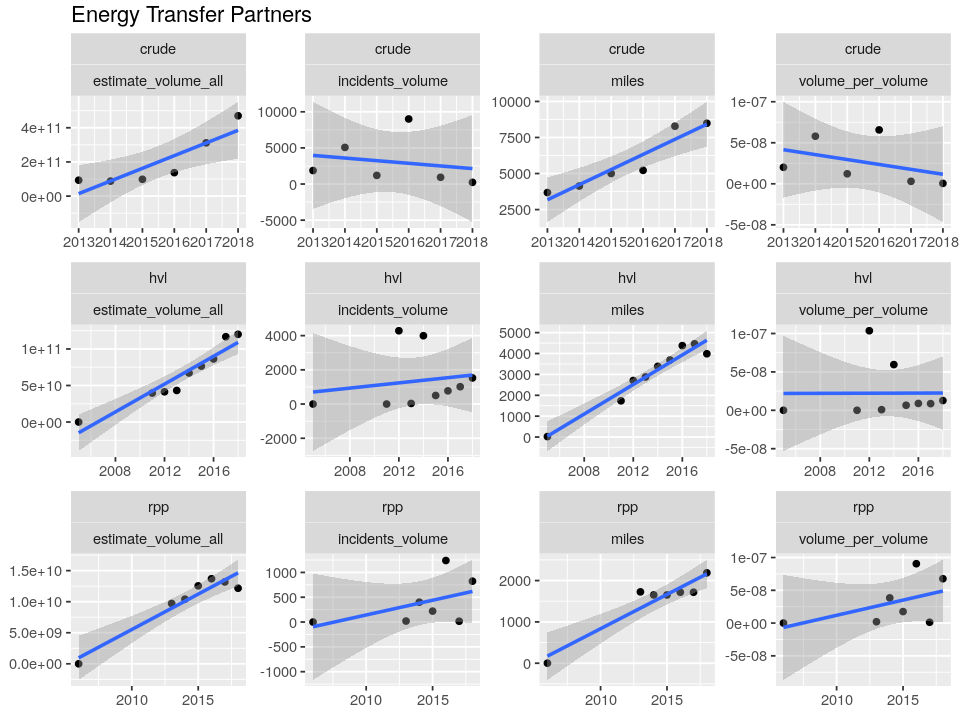

In [36]:
energy_transfer_partners

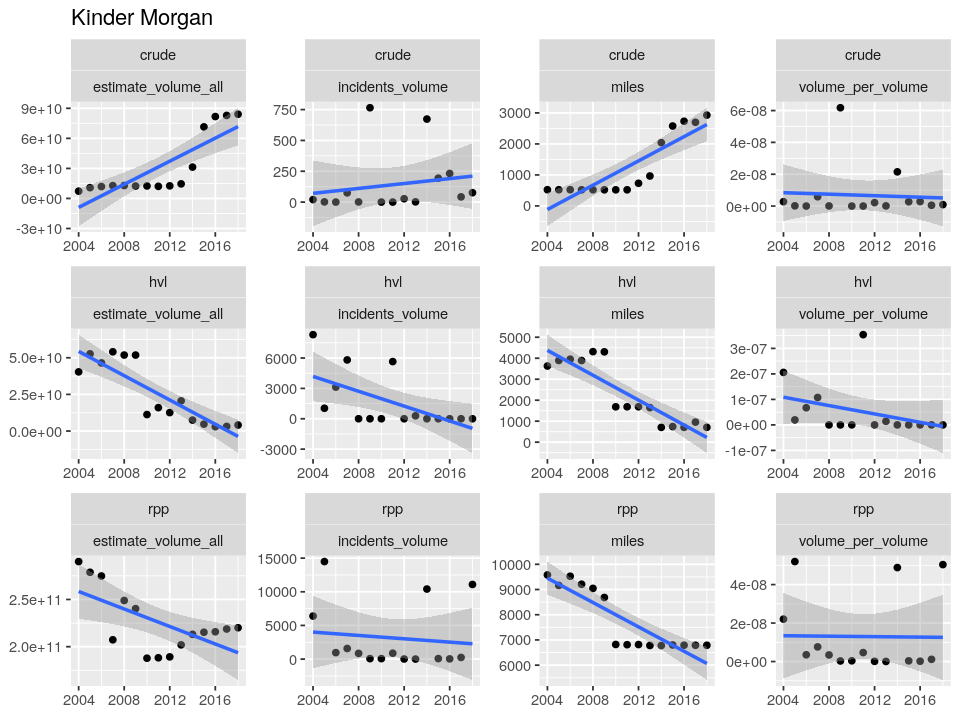

In [37]:
kinder_morgan

* Shows some trends, but nothing consistent between organizations
    * First two organizations expand, but Kinder Morgan does not
    * Enterprise Products Operating expands in HVL, volume increases less fast - good trend
    * Kinder Morgan scales down HVL and RPP - problems for HVL disappear, but RPP shows bad trend when droppign first two years

* Raises some questions on the data
    * Is there data missing for Energy Transfer Partners on crude?
    * Are there problem pipelines?

## Summary

There are different trends for different commodities, and organizations are in different stages of experience with different commodities. These commodities correspond to different, but related technologies. I want to exploit this heterogeneity of technologies and experience for my research. There are also differences between onshore and offshore, but they are not as pronounced as those between commodities. So I might not persue those further, or only superficially. I will focus on onshore.

In terms of variables, I will probably volume transported (in gallon-miles) more accurately catpures activities. There are some limitations on data availability, but I can cope with those challenges. However, when standardizing by volume being transported, an increase in volume being transported can mask that the same pipeline is experiencing a constant, or growing error rate. The pipelines would appear to become "safer" relative to volume being transported.

### Developments

* Improvements for crude, some for HVL.

* Improvements may be driven by cost.